In [60]:
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import yaml
import torch
import IPython

from networks.tacotron import Tacotron
from utils.utilities import _trim_model_state_dict
from utils.audio_processor import AudioProcessor
from utils.audio_utils import denormalize_spectrogram, find_endpoint
from utils.text_utils import text_to_sequence

In [7]:
MODEL_PATH = '../Text2Speech/tts/trained_models/checkpoint_45496.pth.tar'
CONFIG_PATH = 'configs/config.yaml'
OUT_FOLDER = 'model_output'
with open(CONFIG_PATH) as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
use_cuda = torch.cuda.is_available()

In [9]:
audio_configs = configs["audio"]
model = Tacotron(configs["embedding_size"],
                     audio_configs["frequency"],
                     audio_configs["mels_size"],
                     configs["r"])
checkpoint = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model'])

model = model.eval()
if use_cuda:
    model = model.to("cuda")

In [12]:
ap = AudioProcessor(
    audio_configs["sample_rate"],
    audio_configs["preemphasis"],
    audio_configs["frequency"],
    audio_configs["frame_length"],
    audio_configs["frame_shift"],
    audio_configs["min_dbs"],
    audio_configs["ref_dbs"],
    audio_configs["mels_size"],
    audio_configs["griff_lim_iters"],
    audio_configs["spectro_power"]
)

In [24]:
def inference(text):
    text_cleaner = [configs["text_cleaner"]]
    seq = np.array(text_to_sequence(text, text_cleaner))
    with torch.no_grad():
        if use_cuda:
            chars = torch.from_numpy(seq).unsqueeze(0).cuda()
        else:
            chars = torch.from_numpy(seq).unsqueeze(0)
    
    mel_out, linear_out, alignments = model.forward(chars)
    linear_out = linear_out[0].data.cpu().numpy()
    alignment = alignments[0].cpu().data.numpy()
    spectrogram = denormalize_spectrogram(linear_out, audio_configs["min_dbs"])
    wav = ap.spectrogram_to_wav(linear_out.T)
    wav = wav[:find_endpoint(wav, audio_configs["sample_rate"])]
    return wav, alignment, spectrogram   
        

In [48]:
def visualize_spectrogram(spectrogram, alignment):
    plt.figure(figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.imshow(spectrogram, aspect='auto', origin='bottom', 
                       interpolation='none')
    plt.title('Spectrogram')
    plt.xlabel("Time")
    plt.ylabel('Frequency(Hz)')

    plt.subplot(2, 2, 2)
    plt.imshow(alignment, aspect='auto', origin='bottom', 
                       interpolation='none')
    plt.title("Alignment")
    plt.xlabel("Time")
    plt.ylabel('Frequency(Hz)')
    
    plt.show()

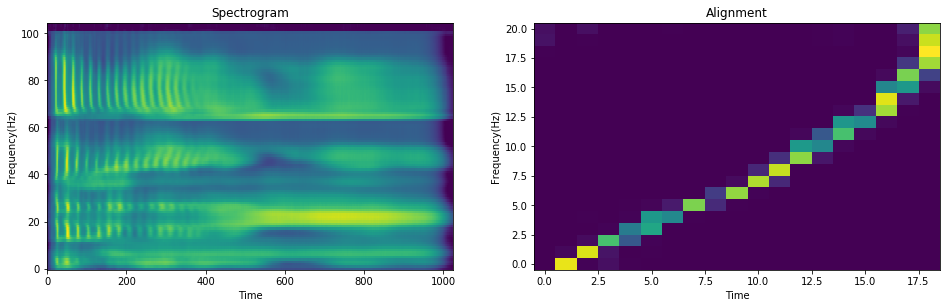

In [49]:
text0 = "It was a great day"
wav, alignment, spectrogram = inference(text0)
IPython.display.display(Audio(wav, rate=audio_configs["sample_rate"]))
visualize_spectrogram(spectrogram, alignment)

In [14]:
def create_speech(m, s, CONFIG, use_cuda, ap):
    text_cleaner = [CONFIG.text_cleaner]
    seq = np.array(text_to_sequence(s, text_cleaner))

    #     mel = np.zeros([seq.shape[0], CONFIG.num_mels, 1], dtype=np.float32)

    if use_cuda:
        chars_var = torch.autograd.Variable(
            torch.from_numpy(seq), volatile=True).unsqueeze(0).cuda()
    else:
        chars_var = torch.autograd.Variable(
            torch.from_numpy(seq), volatile=True).unsqueeze(0)

    mel_out, linear_out, alignments = m.forward(chars_var)
    linear_out = linear_out[0].data.cpu().numpy()
    alignment = alignments[0].cpu().data.numpy()
    spectrogram = denormalize_spectrogram(linear_out)
    wav = ap.spectrogram_to_wav(linear_out.T)
    wav = wav[:ap.find_endpoint(wav)]
    return wav, alignment, spectrogram


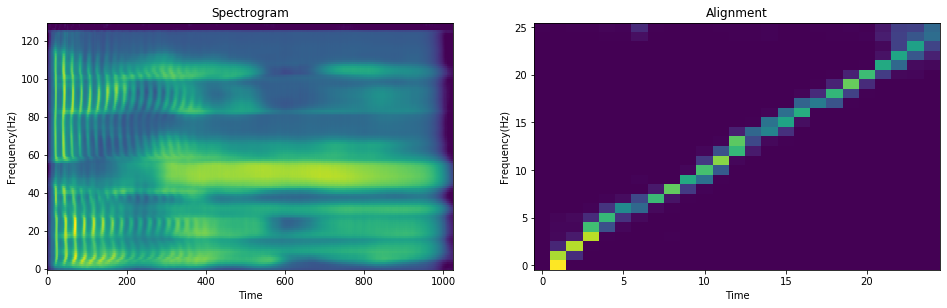

In [51]:
text1 = "I love Machine Learning"
wav, alignment, spectrogram = inference(text1)
IPython.display.display(Audio(wav, rate=audio_configs["sample_rate"]))
visualize_spectrogram(spectrogram, alignment)

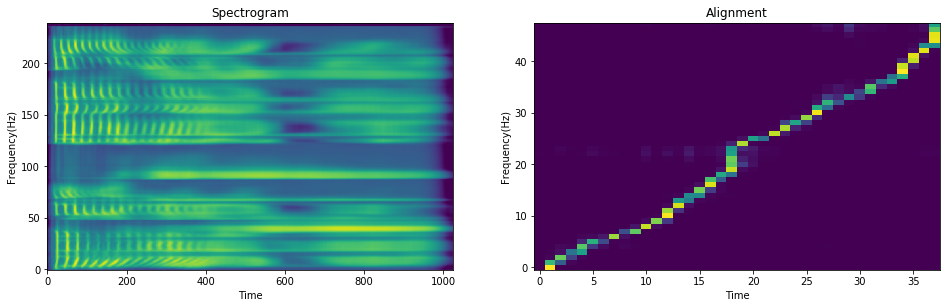

In [58]:
text2 = "My name is Pytorch and I live on cuda"
wav, alignment, spectrogram = inference(text2)
IPython.display.display(Audio(wav, rate=audio_configs["sample_rate"]))
visualize_spectrogram(spectrogram, alignment)

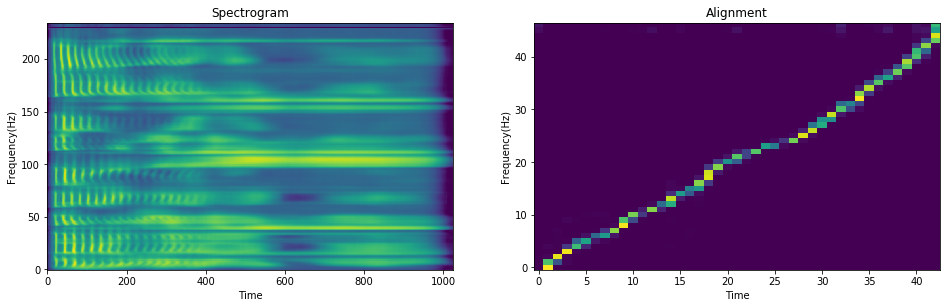

In [63]:
text3 = "I gonna take my horse to the old town road"
wav, alignment, spectrogram = inference(text3)
IPython.display.display(Audio(wav, rate=audio_configs["sample_rate"]))
visualize_spectrogram(spectrogram, alignment)